# Experiment 1 - Minimum Balancing with 224x224 Resizing

This experiment consists on the pre-processing data pipeline established below:

- Data Balancing with Reduction + Oversampling, resulting in 2,100 training images as final dataset.
- Image Resizing to 224x224 in order to improve performance.
- Pixel Values Normalisation to range 0 to 1.

No further data augmentation was implemented during this experiment

## Initial Setup

This initial setup is used to allow direct import of classes from other Notebooks available on Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

## Libraries Import

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
import matplotlib.pyplot as plt
import time
import os

## Instances of the class

In [4]:
db = DataBalancer()
dp = DataPreparer()
msp = ModelSpecificProcessor()

## Train Data Pre-Processing

### Capture and prepare labels data

In this step, the csv file containing diagnosis of lesion type is captured into a dataframe and transformed to provide labels in a single lesion type feature, encode categorical labels, and store image full path based on Google Drive folder structure.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df = dp.labelPathMapper(df, 'train')
df.head()

,image,lesion_type,label_encoded,img_path
0,ISIC_0024306,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,NV,0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,MEL,1,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [7]:
# Check for any issues with img_path
missing_files = [f for f in df['img_path'].values if not os.path.exists(f)]
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print("Example missing path:", missing_files[0])

Missing files: 0


### Data Balancing

For this experiment, the data balance consists of capturing n random samples of each category where n = the record count of the smallest lesion type in the dataset. Based on ISIC 2018 Train Dataset, as observed in file ISIC2018_Task3_Data_Analysis, this corresponds to lesion DF with 115 records.<br><br>
There are 7 categories, which when sampled to 115 per categories provides 805 records. This is insufficient data for training purposes, therefore oversampling is performed to achieve 300 images per categories, providing 2,100 records for training.

In [8]:
ds_train = db.minBalancing(df)

### Image Resizing and Normalisation

In [9]:
HEIGHT = 224
WIDTH = 224

def resize_wrapper(path, label):
    return dp.imageResizer(path, label, HEIGHT, WIDTH)

ds_train = ds_train.map(resize_wrapper)

In [10]:
ds_train = ds_train.map(dp.pixelNormalizer)

In [11]:
BATCH_SIZE = 32

# Update shape to match model Sequential.call() shape
ds_train = ds_train.batch(BATCH_SIZE)

## Validation and Test Data Pre-Processing

In [12]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
df_validate = dp.labelPathMapper(df_validate, 'validate')

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
df_test = dp.labelPathMapper(df_test, 'test')

In [13]:
# Build image tensorflow dataset

ds_validate = db.buildDS(df_validate)
ds_test = db.buildDS(df_test)

In [14]:
# Image resizing 64x64

ds_validate = ds_validate.map(resize_wrapper)
ds_test = ds_test.map(resize_wrapper)

In [15]:
# Pixel values normalisation

ds_validate = ds_validate.map(dp.pixelNormalizer)
ds_test = ds_test.map(dp.pixelNormalizer)

In [16]:
# Update shape to match model Sequential.call() shape

ds_validate = ds_validate.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

## Model Building, Training and Validating

In [17]:
NUM_CLASSES = len(df.lesion_type.unique())
CHANNELS = 3
EPOCHS = 16

In [18]:
# Function to support epoch plotting

def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Custom CNN

In [29]:
modelCNN = models.Sequential([
    # Convolution and Pooling Layers (3 layers of each)
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

    layers.Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

    layers.Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

    # Flatten output into a 1-dimensional tensor
    layers.Flatten(),

    # Fully-Connected Layers
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

modelCNN.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelCNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,567 (42.64 MB)

 Trainable params: 11,178,119 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
start_time = time.time()
histCNN = modelCNN.fit(ds_train, epochs=EPOCHS, validation_data=ds_validate)
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - accuracy: 0.6522 - loss: 26.0577 - val_accuracy: 0.0155 - val_loss: 94.1261
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.4307 - loss: 92.9082 - val_accuracy: 0.0155 - val_loss: 78.2302
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.2725 - loss: 33.6222 - val_accuracy: 0.0052 - val_loss: 15.0465
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.2286 - loss: 14.4839 - val_accuracy: 0.0052 - val_loss: 1.9471
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.1167 - loss: 5.3262 - val_accuracy: 0.0363 - val_loss: 2.4637
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.0599 - loss: 3.1549 - val_accuracy: 0.0415 - val_loss: 2.1213
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.0727 - loss: 2.5529 - val_accuracy: 0.0518 - val_loss: 2.1584
Epoch 8/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.0666 - loss: 2.4128 - val_accuracy: 0.0

In [31]:
loss, accuracy = modelCNN.evaluate(ds_validate)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 951ms/step - accuracy: 0.5689 - loss: 2.5188
Overall accuracy on validation set: 57.51%


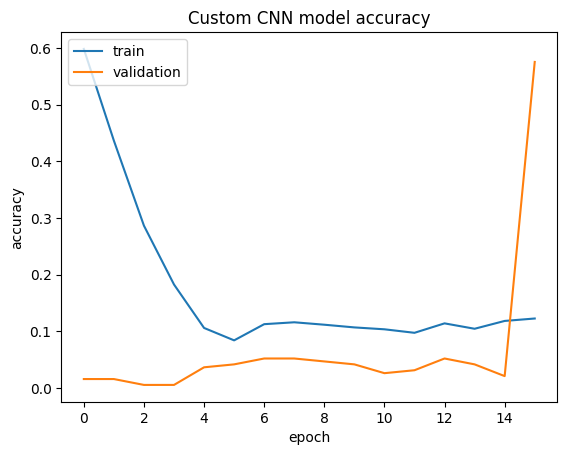

In [32]:
plot_hist(histCNN, "Custom CNN")

### EfficientNet Models

EfficientNet is a family of Convolutional Neural Networks (CNNs) that scales up models using compound coefficient, which uniformally scales each dimension with fixed coefficients, simultaneously increasing width, depth, and resolution.

In [19]:
ds_train_EN = ds_train.map(msp.efficientNetPrep)
ds_validate_EN = ds_validate.map(msp.efficientNetPrep)
ds_test_EN = ds_test.map(msp.efficientNetPrep)

#### EfficientNet-B0

In [20]:
base_modelENB0 = EfficientNetB0(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
)

modelENB0 = models.Sequential([
    base_modelENB0,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelENB0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENB0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [21]:
start_time = time.time()
hist = modelENB0.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B0 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 651s 9s/step - accuracy: 0.6528 - loss: 2.3973 - val_accuracy: 0.0052 - val_loss: 4.2833
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 545s 8s/step - accuracy: 0.2897 - loss: 2.0297 - val_accuracy: 0.0155 - val_loss: 24.0607
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 560s 8s/step - accuracy: 0.1876 - loss: 3.0781 - val_accuracy: 0.0466 - val_loss: 2.1685
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 548s 8s/step - accuracy: 0.3909 - loss: 1.8919 - val_accuracy: 0.0155 - val_loss: 6.5955
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 547s 8s/step - accuracy: 0.4702 - loss: 1.8040 - val_accuracy: 0.6373 - val_loss: 5.7601
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 552s 8s/step - accuracy: 0.4759 - loss: 1.4951 - val_accuracy: 0.1088 - val_loss: 3.6790
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 544s 8s/step - accuracy: 0.5069 - loss: 1.7539 - val_accuracy: 0.0155 - val_loss: 1.7730
Epoch 8/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 561s 8s/step - accuracy: 0.5240 - loss: 1.5148 - val_accuracy: 0.0155 - 

In [24]:
loss, accuracy = modelENB0.evaluate(ds_validate_EN)
print(f"Overall accuracy on validation set: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0084 - loss: 3.4397
Overall accuracy on validation set: 1.55%


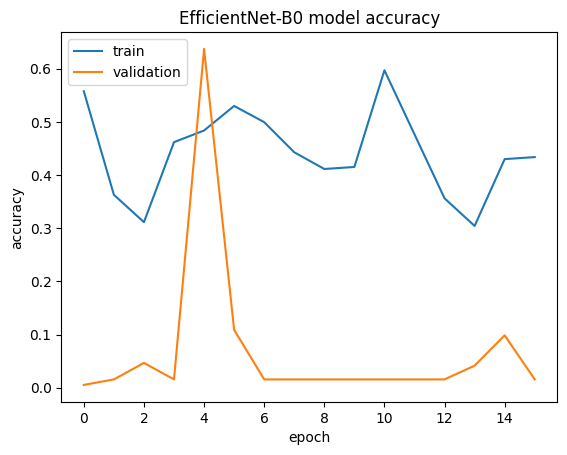

In [22]:
plot_hist(hist, "EfficientNet-B0")

#### EfficientNet-B4

In [ ]:
base_modelENB4 = EfficientNetB4(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="efficientnetb4",
)

modelENB4 = models.Sequential([
    base_modelENB4,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelENB4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENB4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 2, 2, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,134,630 (69.18 MB)

 Trainable params: 18,009,423 (68.70 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
start_time = time.time()
histENB4 = modelENB4.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B4 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histENB4, "EfficientNet-B4")

#### EfficientNet-B7

In [ ]:
base_modelENB7 = EfficientNetB7(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="efficientnetb7",
)

modelENB7 = models.Sequential([
    base_modelENB7,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelENB7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENB7.summary()

In [ ]:
start_time = time.time()
histENB7 = modelENB7.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNet-B7 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histENB7, "EfficientNet-B7")

#### EfficientNetV2-M

In [ ]:
base_modelENV2M = EfficientNetV2M(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="efficientnetv2-m",
)

modelENV2M = models.Sequential([
    base_modelENV2M,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelENV2M.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelENV2M.summary()

In [ ]:
start_time = time.time()
histENV2M = modelENV2M.fit(ds_train_EN, epochs=EPOCHS, validation_data=ds_validate_EN)
end_time = time.time()
duration = end_time - start_time
print(f"Model EfficientNetV2-M Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histENV2M, "EfficientNetV2-M")

### ResNet Models

In [ ]:
ds_train_RN = ds_train.map(msp.resNetPrep)
ds_validate_RN = ds_validate.map(msp.resNetPrep)
ds_test_RN = ds_test.map(msp.resNetPrep)

#### ResNet50V2

In [ ]:
base_modelRN50V2 = ResNet50V2(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="resnet50v2",
)

modelRN50V2 = models.Sequential([
    base_modelRN50V2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelRN50V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelRN50V2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,143 (91.90 MB)

 Trainable params: 24,045,703 (91.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
start_time = time.time()
histRN50V2 = modelRN50V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet50V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.4675 - loss: 2.0388 - val_accuracy: 0.0777 - val_loss: 79.0152
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 383s 6s/step - accuracy: 0.0652 - loss: 1.9336 - val_accuracy: 0.0777 - val_loss: 4.1029
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 377s 6s/step - accuracy: 0.0883 - loss: 1.8392 - val_accuracy: 0.0777 - val_loss: 1.8768
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 389s 6s/step - accuracy: 0.1357 - loss: 1.8194 - val_accuracy: 0.1088 - val_loss: 2.5705
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 354s 5s/step - accuracy: 0.0132 - loss: 1.9650 - val_accuracy: 0.0052 - val_loss: 3.2678
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.3516 - loss: 1.6454 - val_accuracy: 0.0052 - val_loss: 2.7685
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.4305 - loss: 1.3488 - val_accuracy: 0.6373 - val_loss: 1.7384
Epoch 8/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.5454 - loss: 1.1808 - val_accuracy: 0.0155 - 

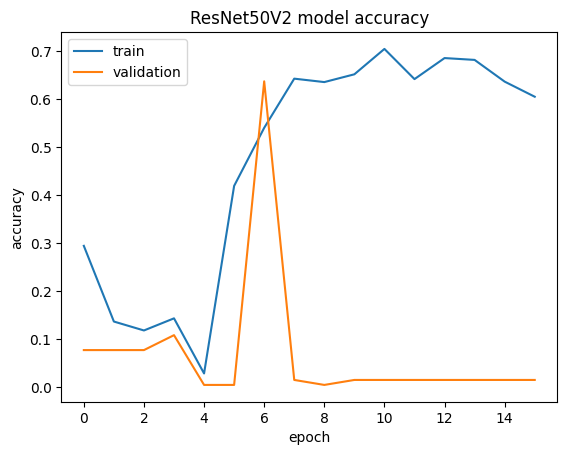

In [ ]:
plot_hist(histRN50V2, "ResNet50V2")

#### ResNet152V2

In [ ]:
base_modelRN152V2 = ResNet152V2(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="resnet152v2",
)

modelRN152V2 = models.Sequential([
    base_modelRN152V2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelRN152V2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelRN152V2.summary()

In [ ]:
start_time = time.time()
histRN152V2 = modelRN152V2.fit(ds_train_RN, epochs=EPOCHS, validation_data=ds_validate_RN)
end_time = time.time()
duration = end_time - start_time
print(f"Model ResNet152V2 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histRN152V2, "ResNet152V2")

### Inception Models

In [ ]:
ds_train_IN = ds_train.map(msp.inceptionPrep)
ds_validate_IN = ds_validate.map(msp.inceptionPrep)
ds_test_IN = ds_test.map(msp.inceptionPrep)

#### InceptionV3

In [ ]:
base_modelINV3 = InceptionV3(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="inception_v3",
)

modelINV3 = models.Sequential([
    base_modelINV3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelINV3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelINV3.summary()

In [ ]:
start_time = time.time()
histINV3 = modelINV3.fit(ds_train_IN, epochs=EPOCHS, validation_data=ds_validate_IN)
end_time = time.time()
duration = end_time - start_time
print(f"Model InceptionV3 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histINV3, "InceptionV3")

### DenseNet Models

In [ ]:
ds_train_DN = ds_train.map(msp.denseNetPrep)
ds_validate_DN = ds_validate.map(msp.denseNetPrep)
ds_test_DN = ds_test.map(msp.denseNetPrep)

#### DenseNet121

In [ ]:
base_modelDN121 = DenseNet121(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="densenet121",
)

modelDN121 = models.Sequential([
    base_modelDN121,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelDN121.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN121.summary()

In [ ]:
start_time = time.time()
histDN121 = modelDN121.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet121 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histDN121, "DenseNet121")

#### DenseNet201

In [ ]:
base_modelDN201 = DenseNet201(
    include_top=False,
    weights="imagenet", # transfer learning
    classes=NUM_CLASSES,
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    name="densenet201",
)

modelDN201 = models.Sequential([
    base_modelDN201,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

modelDN201.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

modelDN201.summary()

In [ ]:
start_time = time.time()
histDN201 = modelDN201.fit(ds_train_DN, epochs=EPOCHS, validation_data=ds_validate_DN)
end_time = time.time()
duration = end_time - start_time
print(f"Model DenseNet201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

In [ ]:
plot_hist(histDN201, "DenseNet201")